In [66]:
'''
This file shows how to find a transport map from data. That is, we start with
$N$ samples from an arbitrary distribution $\pi$ (1D in this example) and
construct a map $S$ which maps $\pi$ to a 1D standard normal $\pi_{tar}$ (also
called $\eta$). To be consistent with terminology of the direct maps, the
``target'' distribution is $\pi_{tar} = \eta$ and the ``reference'' distribution is $\pi$.
'''
import warnings
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import TransportMaps as TM
import TransportMaps.Functionals as FUNC
import TransportMaps.Maps as MAPS
import TransportMaps.Densities as DENS
%matplotlib inline

In [67]:
nax = np.newaxis

# PLOTTING
fsize = (6,5)
discr = 51

# Initial set up
setup = {}
test = {}
setup['dim'] = 1
setup['refplotspan'] = np.array([[-7.,7.]])
setup['plotspan'] = np.array([[-6.,6.]])

In [68]:
# Define a class for the reference density based on samples
class SamplesDensity(DENS.Density):
    r""" Arbitrary density built from samples
    """
    def __init__(self, samples):
        super(SamplesDensity,self).__init__(samples.shape[1])
        self.samples = samples

    def rvs(self, m):
        if m > self.samples.shape[0]:
            raise ValueError("Number of rvs must be less than or equal to length of samples provided")

        msamples = self.samples[0:m,:]
        return msamples

    def quadrature(self, qtype, qparams):
        if qtype == 0:
            x = self.rvs(qparams)
            w = np.ones(qparams)/qparams
        else:
            raise NotImplementedError("Not implemented because sample density only has quadrature via samples")
        return (x,w)

    # Define if no analytical form of pdf
    def pdf(self, x, params=None):
        if self.samples.shape[1] == 1:
            samps = self.samples.flatten()
        else:
            samps = self.samples

        # kde takes data in form (#dim, #data)
        density = stats.gaussian_kde(samps.T)
        pdf_kde = density.evaluate(x.T)
        return pdf_kde

    def log_pdf(self, x, params=None):
        if self.samples.shape[1] == 1:
            samps = self.samples.flatten()
        else:
            samps = self.samples
        # kde takes data in form (#dim, #data)
        density = stats.gaussian_kde(samps.T)
        pdf_kde = density.evaluate(x.T)
        return np.log(pdf_kde)

In [69]:
# In this example, the samples will be generated according to a mixed gaussian distribution
class MixedNormal(DENS.Density):
  def __init__(self, mu1, sigma1, mu2, sigma2):
    self.mu1 = mu1
    self.sigma1 = sigma1
    self.mu2 = mu2
    self.sigma2 = sigma2

  def pdf(self,x,params=None):
    out = .5*stats.norm.pdf(x, loc = self.mu1, scale = self.sigma1) + .5*stats.norm.pdf(x,
        loc = self.mu2, scale = self.sigma2)
    return out.flatten()

  def log_pdf(self,x,params=None):
    pdf = .5*stats.norm.pdf(x, loc = self.mu1, scale = self.sigma1) + .5*stats.norm.pdf(x,
        loc = self.mu2, scale = self.sigma2)
    out = np.log(pdf)
    return out.flatten()

  def rvs(self,n):
    data1 = stats.norm.rvs(self.mu1, self.sigma1, size=int(n/2))
    data2 = stats.norm.rvs(self.mu2, self.sigma2, size=int(n/2))
    out = np.concatenate([data1,data2])
    return out

  def quadrature(self,qtype,qparams):
    if qtype == 0:
      x = qparams
      l = qparams.shape[0]
      w = np.ones(l)/l
    else:
      raise NotImplementedError("Not implemented")
    return (x,w)

In [70]:
# Use 1000 samples to generate map
N_samp = 1000
m1 = 0; s1 = 1;
m2 = 3; s2 = 1;

# Reference density is mixed normal as defined by class above
ref_den = MixedNormal(mu1=m1, mu2 = m2, sigma1 = s1,
        sigma2 = s2)

# Generate data (the samples)
data = ref_den.rvs(N_samp)
if data.ndim == 1:
    data = data[:,nax]

# Will map from reference (or base) samples to standard normal
test['base_density'] = SamplesDensity(data)
test['target_density'] = DENS.StandardNormalDensity(setup['dim'])

In [71]:
# APPROXIMATION
MONOTONE = 'intexp' #use integrated exponential

# REGULARIZATION
# None: No regularization
# L2: L2 regularization
REG = None

# L2 error estimation
# 3: Gauss quadrature of order n
# 0: Monte Carlo quadrature with n point
qtype = 0
qparams = math.floor(data.shape[0]) #use all samples in quadrature

# Gradient information
# 0: derivative free
# 1: gradient information
# 2: Hessian information
ders = 2

# Approximation order
order = 5
# Tolerance
tol = 1e-6

In [72]:
# Generate samples of reference and target
ref_samp = data
tar_samp = test['target_density'].rvs(N_samp)

In [73]:
# PLOTTING PRE-COMPUTATION
# Start plotting of the 1d map
pspan = setup['plotspan']
rspan = setup['refplotspan']

# Plot the 1d map
X1d = np.vstack( (np.linspace(rspan[0,0],rspan[0,1],discr),
                  np.zeros((setup['dim']-1,discr))) ).T

# Compute map S = F_eta^-1 (F_z) where z ~ \pi and \eta is standard normal
# Compute empirical cdf if no analytical cdf
num_bins = 100;
counts, bin_edges = np.histogram(data,bins=num_bins,normed=True)
dx = bin_edges[1] - bin_edges[0]
ecdf = np.cumsum(counts*dx)
ecdf_eval = np.interp(X1d[:,0],bin_edges[1:],ecdf)
t1 = stats.norm.ppf(ecdf_eval)

In [74]:
# Build the transport map (isotropic for each entry)
tm_approx = TM.Default_IsotropicIntegratedExponentialTriangularTransportMap(
       setup['dim'], order, active_vars=None)
# Construct density
# Density S_\sharp \pi
tm_density = DENS.PushForwardTransportMapDensity(tm_approx, test['base_density'])
# Target density to be approximated
target_density = test['target_density']

# SOLVE
tm_density.minimize_kl_divergence(target_density,
                                  qtype=qtype,
                                  qparams=qparams,
                                  regularization=REG,
                                  tol=tol, ders=ders)

Optimization terminated successfully.
         Current function value: 1.927116
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 22
         Hessian evaluations: 11


[12, 22, 11]

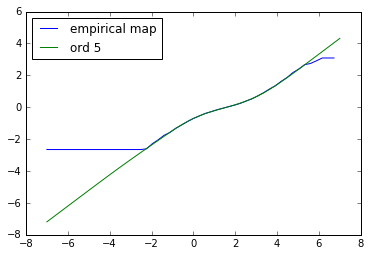

In [75]:
# Plot the empirical map and the optimized map
fig_map_1d = plt.figure()
ax_map_1d = fig_map_1d.add_subplot(1,1,1)
ax_map_1d.plot(X1d[:,0], t1, label='empirical map')

# Map to S_\sharp \pi
t1_approx = tm_density.map_samples_base_to_target(X1d)
# Plot 1d transport map
ax_map_1d.plot(X1d[:,0], t1_approx, label='ord %d' % order)
fig_map_1d.gca().legend(loc=2)

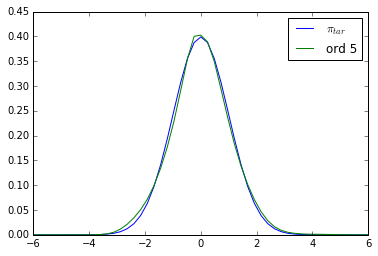

In [76]:
# Plot the target distribution (standard normal)
fig_kde_1d = plt.figure()
ax_kde_1d = fig_kde_1d.add_subplot(1,1,1)

X1d_kde = np.linspace(pspan[0,0],pspan[0,1],discr).reshape((discr,1))

# Plot analytic
pdf1d = test['target_density'].pdf(X1d_kde)
ax_kde_1d.plot(X1d_kde, pdf1d, label='$\pi_{tar}$')

# Plot computed
pdf1d_approx = tm_density.pdf(X1d_kde)
ax_kde_1d.plot(X1d_kde, pdf1d_approx, label='ord %d' % order)

fig_kde_1d.gca().legend()

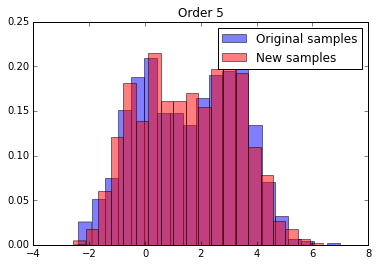

In [77]:
# Push forward reference samples
# Map x from \pi to y from S_\sharp \pi
fapp_samp = tm_density.map_samples_base_to_target( ref_samp )

# Pullback standard normal samples to original samples
norm_samp = stats.norm.rvs(size=N_samp)
norm_samp = norm_samp[:,nax]
new_samp = tm_density.map_samples_target_to_base( norm_samp )

# Plot pullback of inverse map
plt.figure()
p1 = plt.hist(data[:,0],bins=20,normed=1,alpha=.5)
p2 = plt.hist(new_samp[:,0],bins=20,normed=1,alpha=.5,color='r')
plt.legend(["Original samples","New samples"])
plt.title("Order %s" %(order))